In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier


Učitavanje podataka - Nivo vlažnosti, Temperatura, Period u danu, Da li je bogomoljka uspešno namamila svoj plen, Vreme utrošeno na lov, Veličina plena, Da li je bogomoljka lovila iz zasede, Da li su bili prisutni drugi predatori, Da li se bogomoljka takmičila za plen, Da li je bogomoljka bila uspešna u lovu
Odluka: Radiće se klasifikacija za Hunting Success, model na osnovu zadatih parametara treba da predvidi da li je lov bio uspešan ili ne

In [3]:
dataset = pd.read_csv('../data/data.csv')

dataset.head(5)

,Humidity Level,Temperature,Time of Day,Luring Success,Time Spent Hunting,Prey Size,Ambush,Food Availability,Predator Presence,Is Competition,Hunting Success
0,0.32,31.25,Morning,True,0.81,6.60,False,NaN,True,False,0
1,0.66,29.08,Afternoon,False,2.81,5.38,False,Low,False,False,1
2,0.61,25.74,Evening,True,3.79,15.19,True,Low,False,False,1
3,0.37,22.68,Morning,False,4.27,5.06,True,Low,True,False,1
4,0.65,29.20,Afternoon,False,3.84,2.71,False,High,False,False,1


Prikaz osnovnih informacija

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Humidity Level      300000 non-null  float64
 1   Temperature         300000 non-null  float64
 2   Time of Day         300000 non-null  object 
 3   Luring Success      300000 non-null  bool   
 4   Time Spent Hunting  300000 non-null  float64
 5   Prey Size           300000 non-null  float64
 6   Ambush              300000 non-null  bool   
 7   Food Availability   269788 non-null  object 
 8   Predator Presence   270292 non-null  object 
 9   Is Competition      269881 non-null  object 
 10  Hunting Success     300000 non-null  int64  
dtypes: bool(2), float64(4), int64(1), object(4)
memory usage: 21.2+ MB


Prikaz sumirane statistike

In [5]:
dataset.describe()

,Humidity Level,Temperature,Time Spent Hunting,Prey Size,Hunting Success
count,300000.00,300000.00,300000.00,300000.00,300000.00
mean,0.60,27.50,2.73,5.66,0.55
std,0.17,4.33,1.41,2.82,0.50
min,0.30,20.00,0.40,1.00,0.00
25%,0.45,23.75,1.55,3.31,0.00
50%,0.60,27.49,2.69,5.59,1.00
75%,0.75,31.25,3.84,7.88,1.00
max,0.90,35.00,10.19,20.97,1.00


### Analiza raspodele target varijable

In [6]:
hunting_success_dist = dataset['Hunting Success'].value_counts()
print("Raspodela Hunting Success:")
print(hunting_success_dist)
print(f"\nProcenat: {hunting_success_dist / len(dataset) * 100}")

Raspodela Hunting Success:
Hunting Success
1    164957
0    135043
Name: count, dtype: int64

Procenat: Hunting Success
1   54.99
0   45.01
Name: count, dtype: float64


Zapažanje: Dataset je balansiran - obe klase su približno jednako zastupljene.

Provera koliko duplikata postoji u setu podataka

In [7]:
broj_duplikata = dataset.duplicated().sum()
print(f'Broj duplikata: {broj_duplikata}')

Broj duplikata: 0


Zapažanja: kolone 7, 8 i 9 su tipa object, iako u .csv-u imaju vrednosti TRUE i FALSE. 
Pretpostavka: Fale podaci u nekim redovima za ove vrednosti.
Prikazan broj praznih vrednosti po kolonama:

In [8]:
dataset.isnull().sum()

Humidity Level            0
Temperature               0
Time of Day               0
Luring Success            0
Time Spent Hunting        0
Prey Size                 0
Ambush                    0
Food Availability     30212
Predator Presence     29708
Is Competition        30119
Hunting Success           0
dtype: int64

Raspodela broja redova prema broju nedostajućih vrednosti:

In [9]:
dataset.isnull().sum(axis=1).value_counts()

0    218592
1     73107
2      7971
3       330
Name: count, dtype: int64

Procenat broja redova prema broju nedostajućih vrednosti - tabela

In [10]:
raspodela = dataset.isnull().sum(axis=1).value_counts().sort_index()
ukupan_broj_redova = len(dataset)

tabela = pd.DataFrame({
    'Broj nedostajućih vrednosti': raspodela.index,
    'Broj redova': raspodela.values,
    'Procenat (%)': (raspodela.values / ukupan_broj_redova * 100).round(2)
})

tabela


,Broj nedostajućih vrednosti,Broj redova,Procenat (%)
0,0,218592,72.86
1,1,73107,24.37
2,2,7971,2.66
3,3,330,0.11


Zapažanje: Većina redova sa praznim vrednostima ima samo jednu nedefinisanu vrednost.
Može se uraditi: Procenat redova kojima fali više od jedne vrednosti je jako mali(ispod 5%) i njihovo brisanje neće značajno uticati na ishod.
Procenat redova kojima nedostaje jedna vrednost predstavlja veliki deo dataseta i treba ih sačuvati za analizu. Prazne vrednosti se mogu zameniti validnim vrednostima na sledeće načine: 
1. Dopisivanjem FALSE u svako prazno polje - Može iskriviti odnos TRUE/FALSE
2. Probabilistička imputacija - Pronalaženje odnosa vrednosti TRUE/FALSE i popunjavanje dataset-a tako da se održi ova razmera - Očuvava se odnos TRUE/FALSE
3. Model based imputacija - Treniranje modela za popunjavanje vrednosti koje fale

Odabrana je opcija 2.

Brisanje redova sa više nedefinisanih vrednosti:

In [11]:
dataset = dataset[dataset.isnull().sum(axis=1) <= 1]
dataset.info()
dataset.head(5)

<class 'pandas.core.frame.DataFrame'>
Index: 291699 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Humidity Level      291699 non-null  float64
 1   Temperature         291699 non-null  float64
 2   Time of Day         291699 non-null  object 
 3   Luring Success      291699 non-null  bool   
 4   Time Spent Hunting  291699 non-null  float64
 5   Prey Size           291699 non-null  float64
 6   Ambush              291699 non-null  bool   
 7   Food Availability   267110 non-null  object 
 8   Predator Presence   267668 non-null  object 
 9   Is Competition      267212 non-null  object 
 10  Hunting Success     291699 non-null  int64  
dtypes: bool(2), float64(4), int64(1), object(4)
memory usage: 22.8+ MB


,Humidity Level,Temperature,Time of Day,Luring Success,Time Spent Hunting,Prey Size,Ambush,Food Availability,Predator Presence,Is Competition,Hunting Success
0,0.32,31.25,Morning,True,0.81,6.60,False,NaN,True,False,0
1,0.66,29.08,Afternoon,False,2.81,5.38,False,Low,False,False,1
2,0.61,25.74,Evening,True,3.79,15.19,True,Low,False,False,1
3,0.37,22.68,Morning,False,4.27,5.06,True,Low,True,False,1
4,0.65,29.20,Afternoon,False,3.84,2.71,False,High,False,False,1


Procentualni odnos vrednosti u kolonama sa True/False podacima

In [12]:
boolean_kolone = []
for kolona in dataset.columns:
    jedinstvene_vrednosti = dataset[kolona].dropna().unique()
    if set(jedinstvene_vrednosti).issubset({0, 1}):
        boolean_kolone.append(kolona)

rezultati = []
for kolona in boolean_kolone:
    ukupno = dataset[kolona].notna().sum()  
    broj_1 = (dataset[kolona] == 1).sum()
    broj_0 = (dataset[kolona] == 0).sum()
    
    proc_1 = (broj_1 / ukupno * 100).round(2) if ukupno > 0 else 0
    proc_0 = (broj_0 / ukupno * 100).round(2) if ukupno > 0 else 0
    
    rezultati.append({
        'Kolona': kolona,
        'Broj vrednosti TRUE/1': broj_1,
        'Broj vrednosti FALSE/0': broj_0,
        'Procenat TRUE/1 (%)': proc_1,
        'Procenat FALSE/0 (%)': proc_0,
        'Ukupno': ukupno
    })

tabela_boolean = pd.DataFrame(rezultati)
tabela_boolean


,Kolona,Broj vrednosti TRUE/1,Broj vrednosti FALSE/0,Procenat TRUE/1 (%),Procenat FALSE/0 (%),Ukupno
0,Luring Success,145980,145719,50.04,49.96,291699
1,Ambush,145594,146105,49.91,50.09,291699
2,Predator Presence,133661,134007,49.94,50.06,267668
3,Is Competition,133349,133863,49.90,50.10,267212
4,Hunting Success,160315,131384,54.96,45.04,291699


Prevođenje vrednosti kolona sa True/False u 1/0; 
Boolean atributi su transformisani u numerički oblik (0/1) kako bi se omogućila primena algoritama mašinskog učenja koji zahtevaju numeričke ulaze.

In [13]:
kolone = ['Predator Presence', 'Is Competition']

for kolona in kolone:
    dataset[kolona] = dataset[kolona].replace(r'(?i)^true$', 1, regex=True).replace(r'(?i)^false$', 0, regex=True)

for kolona in kolone:
    dataset[kolona] = pd.to_numeric(dataset[kolona], errors='coerce').astype('Int64')

Probabilistička imputacija za kolone sa nedostajućim vrednostima

In [14]:
kolone_boolean = ['Predator Presence', 'Is Competition']

for kol in kolone_boolean:
    p_true = dataset[kol].mean()
    
    dataset[kol] = dataset[kol].apply(
        lambda x: 1 if pd.notna(x) and x == 1 
        else (1 if pd.isna(x) and np.random.rand() < p_true else 0)
    )

if dataset['Food Availability'].isna().any():
    distribucija = dataset['Food Availability'].value_counts(normalize=True)
    kategorije = distribucija.index.tolist()
    verovatnoce = distribucija.values.tolist()
    
    nan_indeksi = dataset['Food Availability'].isna()
    
    dataset.loc[nan_indeksi, 'Food Availability'] = np.random.choice(
        kategorije, 
        size=nan_indeksi.sum(),
        p=verovatnoce,
    )

Transformacija bool TRUE/FALSE vrednosti u numeričke 0/1 int64

In [15]:
dataset = dataset.replace({True: 1, False: 0})

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 291699 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Humidity Level      291699 non-null  float64
 1   Temperature         291699 non-null  float64
 2   Time of Day         291699 non-null  object 
 3   Luring Success      291699 non-null  int64  
 4   Time Spent Hunting  291699 non-null  float64
 5   Prey Size           291699 non-null  float64
 6   Ambush              291699 non-null  int64  
 7   Food Availability   291699 non-null  object 
 8   Predator Presence   291699 non-null  int64  
 9   Is Competition      291699 non-null  int64  
 10  Hunting Success     291699 non-null  int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 26.7+ MB


<b style="background-color: #470047">Zaokruživanje na dve decimale</b> 

In [16]:
num_cols = dataset.select_dtypes(include=['float64']).columns

for col in num_cols:
    dataset[col] = dataset[col].round(2)

dataset.head(5)

,Humidity Level,Temperature,Time of Day,Luring Success,Time Spent Hunting,Prey Size,Ambush,Food Availability,Predator Presence,Is Competition,Hunting Success
0,0.32,31.25,Morning,1,0.81,6.60,0,High,1,0,0
1,0.66,29.08,Afternoon,0,2.81,5.38,0,Low,0,0,1
2,0.61,25.74,Evening,1,3.79,15.19,1,Low,0,0,1
3,0.37,22.68,Morning,0,4.27,5.06,1,Low,1,0,1
4,0.65,29.20,Afternoon,0,3.84,2.71,0,High,0,0,1


Učitavanje obrađenih podataka
Prikaz numerickih deskriptivnih pokazatelja

In [17]:
desc = dataset.describe().round(2)

variance_row = (desc.loc['std'] ** 2).round(2)
variance_row.name = 'variance'
desc = pd.concat([desc, variance_row.to_frame().T])

iqr_row = (desc.loc['75%'] - desc.loc['25%']).round(2)
iqr_row.name = 'IQR'
desc = pd.concat([desc, iqr_row.to_frame().T])

desc = desc.reindex(['count', 'mean', 'std', 'variance', 'min', '25%', '50%', '75%', 'max', 'IQR'])

desc

,Humidity Level,Temperature,Luring Success,Time Spent Hunting,Prey Size,Ambush,Predator Presence,Is Competition,Hunting Success
count,291699.00,291699.00,291699.00,291699.00,291699.00,291699.00,291699.00,291699.00,291699.00
mean,0.60,27.50,0.50,2.73,5.66,0.50,0.50,0.50,0.55
std,0.17,4.33,0.50,1.41,2.82,0.50,0.50,0.50,0.50
variance,0.03,18.75,0.25,1.99,7.95,0.25,0.25,0.25,0.25
min,0.30,20.00,0.00,0.40,1.00,0.00,0.00,0.00,0.00
25%,0.45,23.74,0.00,1.55,3.31,0.00,0.00,0.00,0.00
50%,0.60,27.50,1.00,2.69,5.59,0.00,0.00,0.00,1.00
75%,0.75,31.25,1.00,3.84,7.88,1.00,1.00,1.00,1.00
max,0.90,35.00,1.00,10.19,20.97,1.00,1.00,1.00,1.00
IQR,0.30,7.51,1.00,2.29,4.57,1.00,1.00,1.00,1.00


Histogram

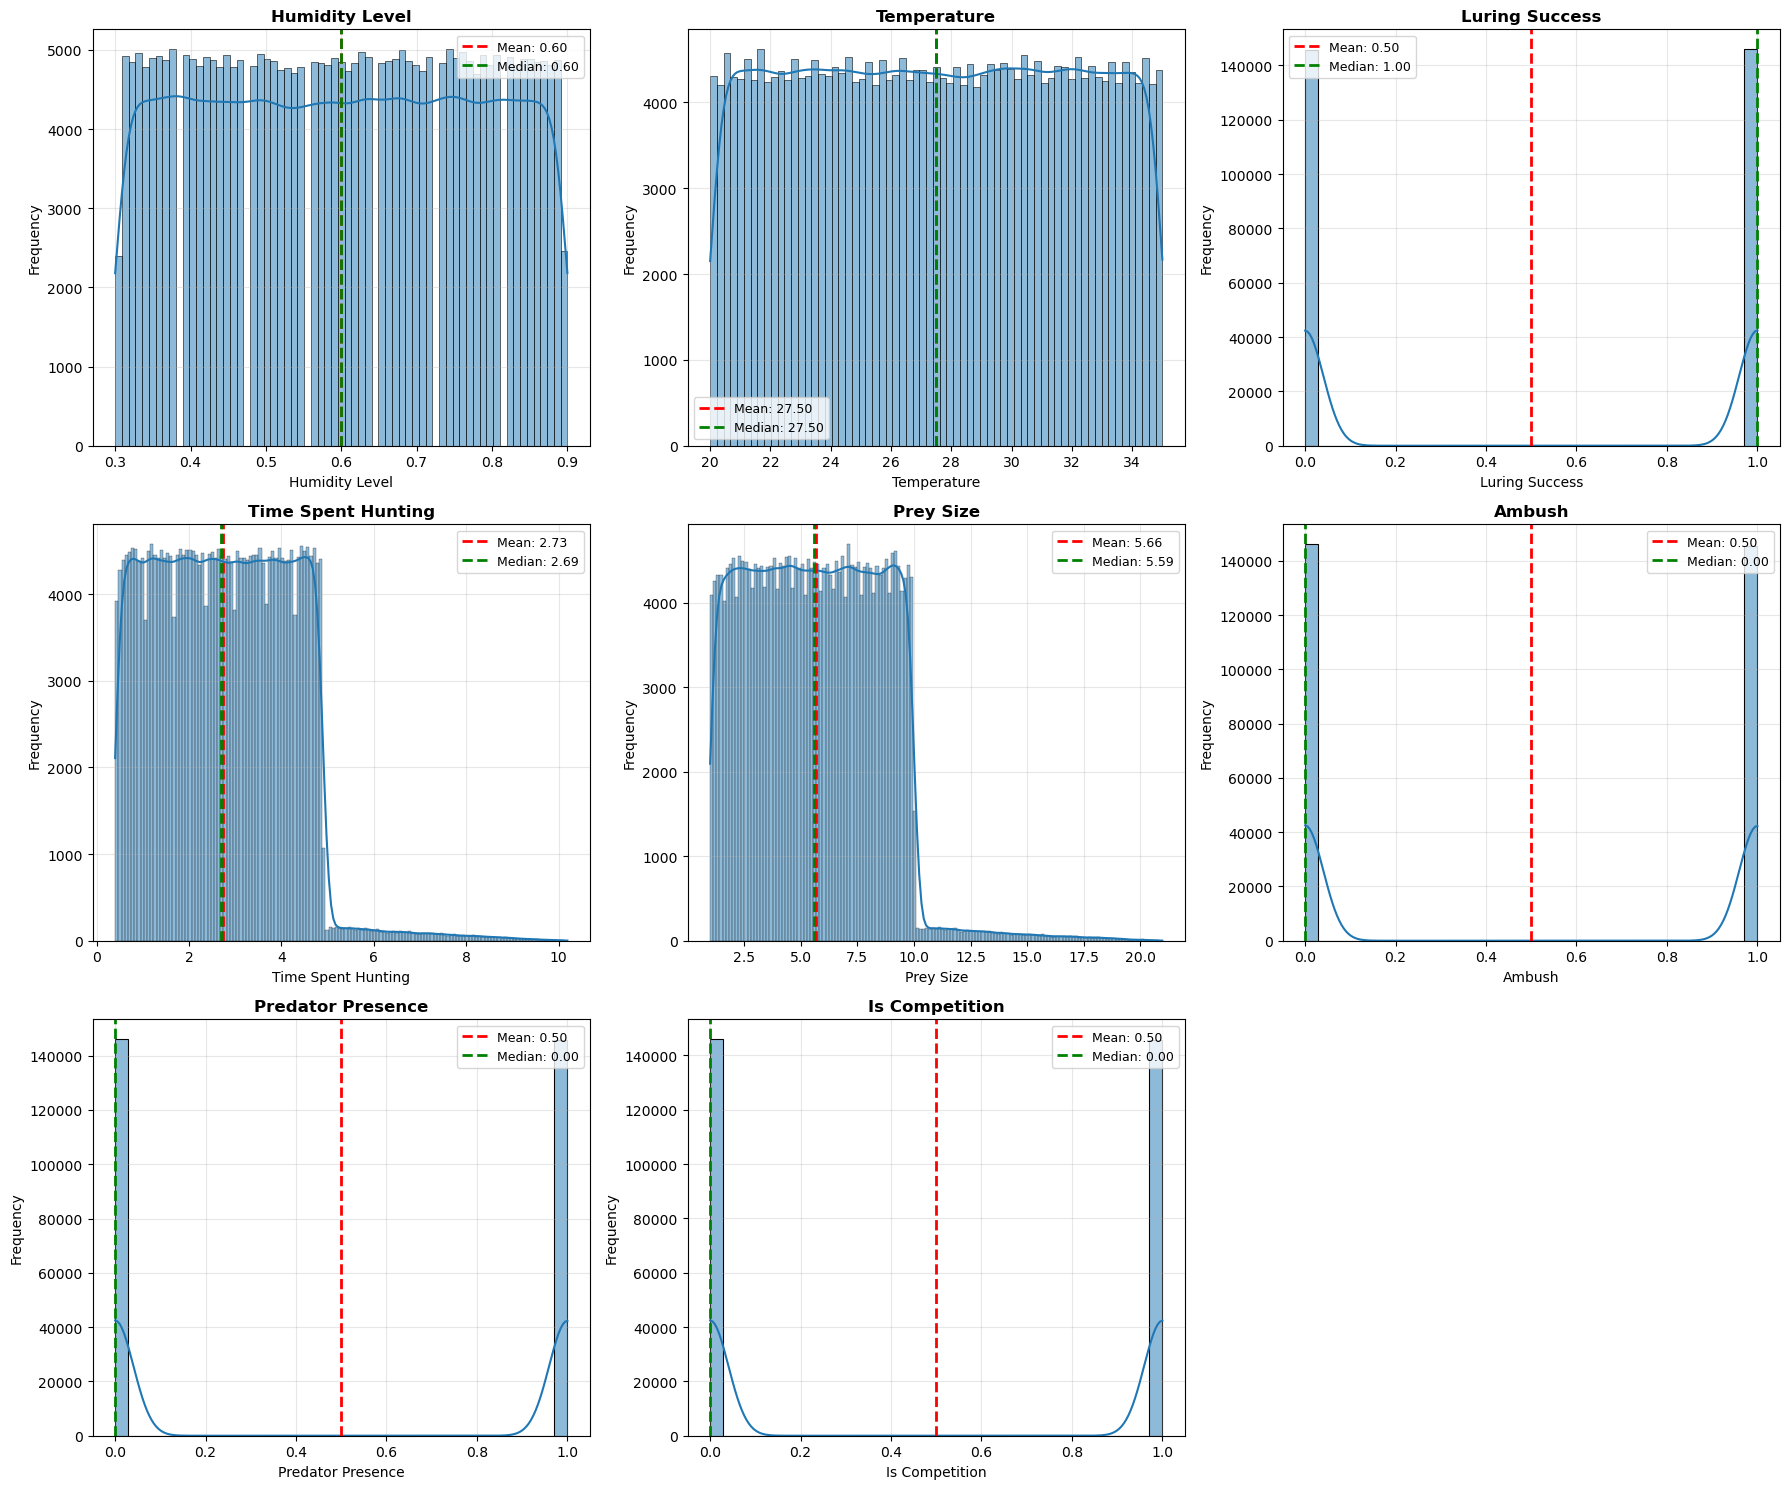

In [18]:
num_cols = dataset.select_dtypes(include=['float', 'int']).columns.tolist()
num_cols.remove('Hunting Success')

n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten() if len(num_cols) > 1 else [axes] if n_rows == 1 else axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(dataset[col], kde=True, ax=axes[i])
    
    mean_val = dataset[col].mean()
    median_val = dataset[col].median()
    
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    
    axes[i].set_title(f'{col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)
    axes[i].legend(fontsize=9)
    axes[i].grid(alpha=0.3)

for i in range(len(num_cols), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Boxplots


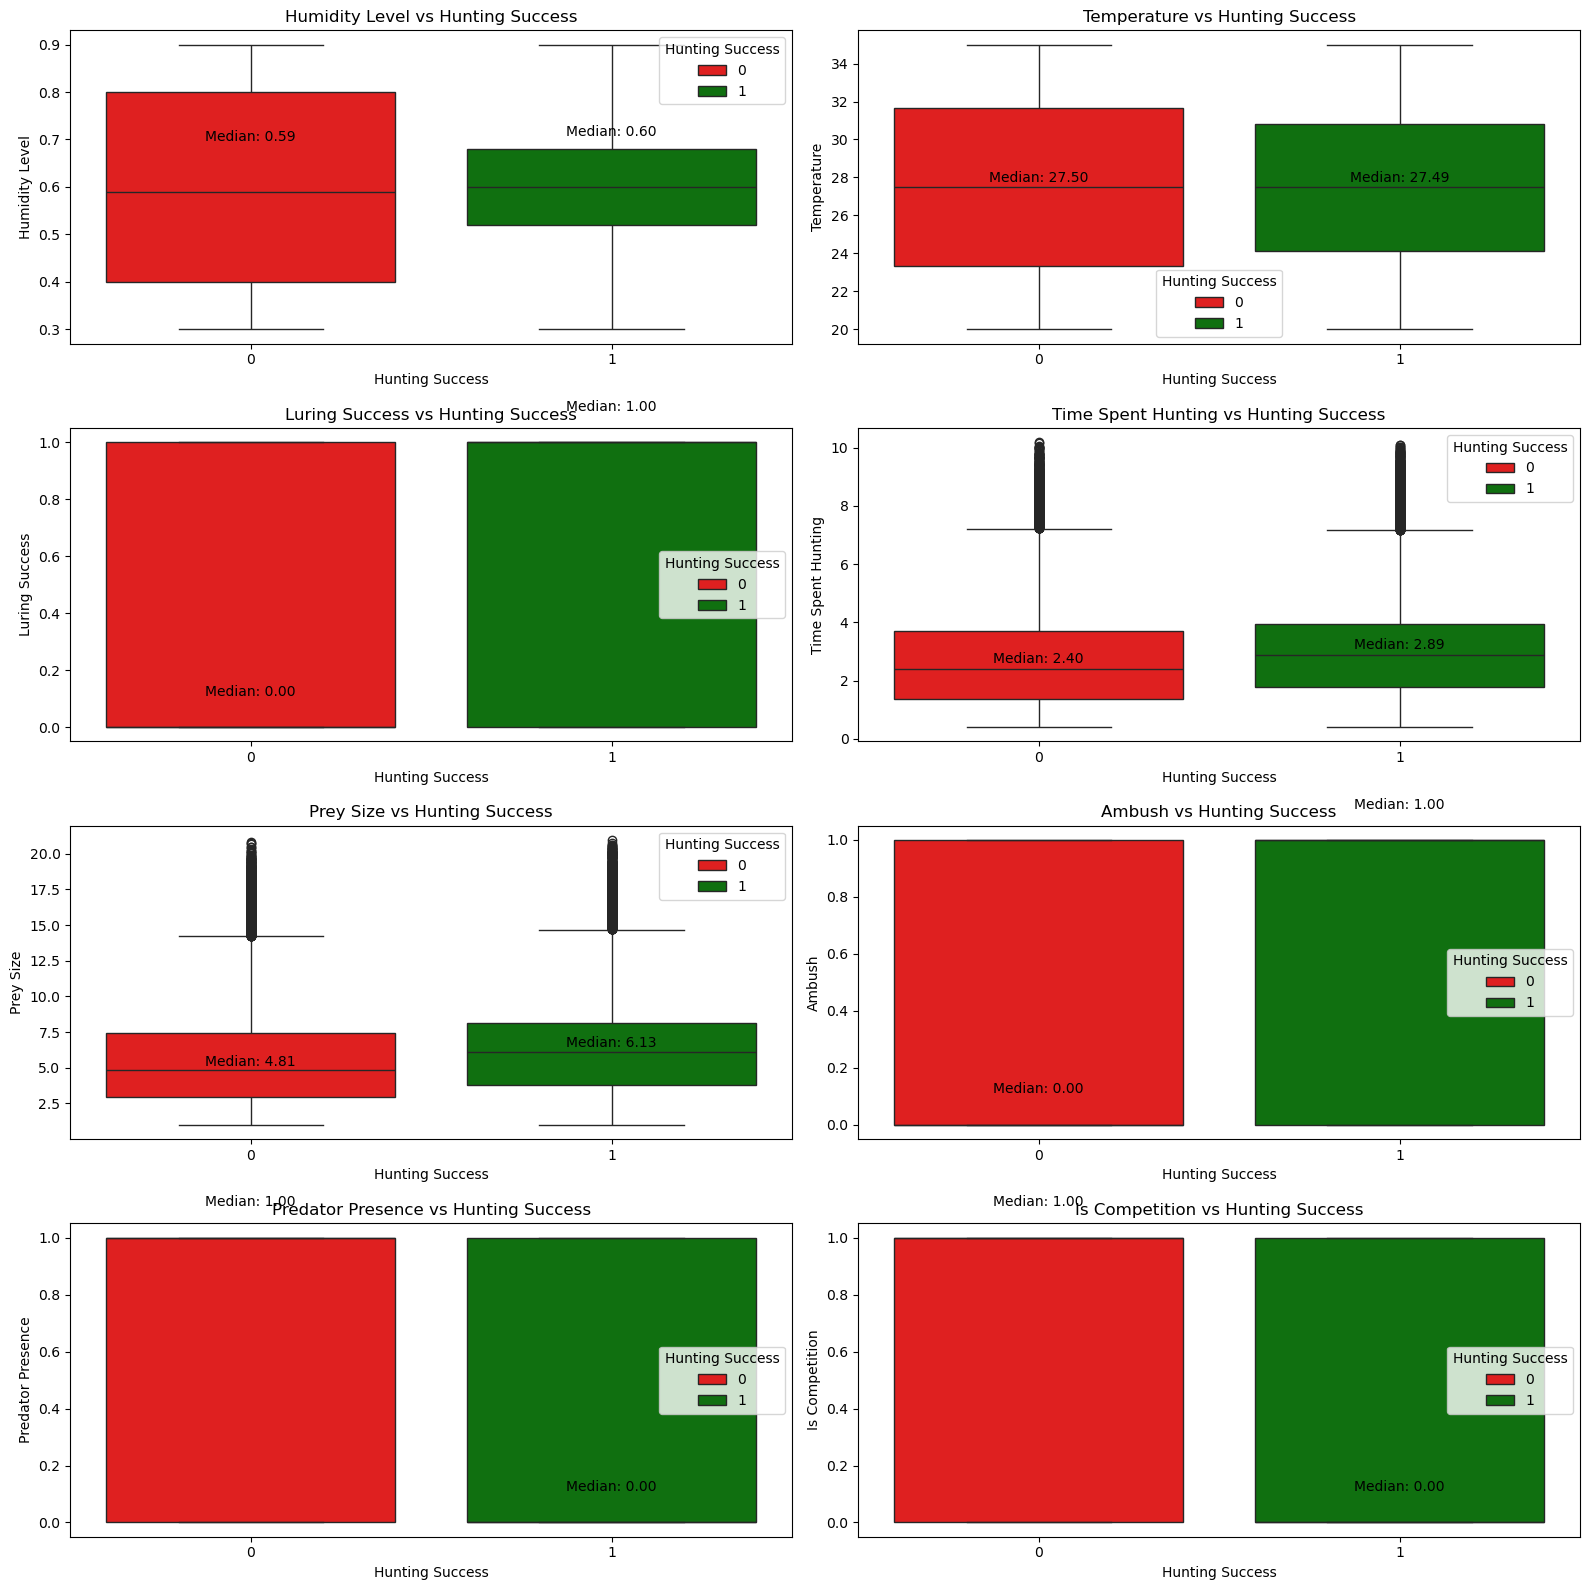

In [19]:
num_cols = dataset.select_dtypes(include=['float', 'int']).columns.tolist()

num_cols.remove('Hunting Success')
n_cols = 2  
n_rows = (len(num_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 4 * n_rows))

for i, col in enumerate(num_cols):
    row = i // n_cols
    col_idx = i % n_cols
    ax = axes[row, col_idx]
    sns.boxplot(x='Hunting Success', y=col, data=dataset, ax=ax, palette=('red', 'green'), hue='Hunting Success')
    ax.set_title(f'{col} vs Hunting Success')

    medians = dataset.groupby('Hunting Success')[col].median()
    for j, median in enumerate(medians):
        ax.text(j, median + 0.1, f'Median: {median:.2f}', ha='center', va='bottom', fontsize=10, color='black')

for i in range(len(num_cols), n_rows * n_cols):
    row = i // n_cols
    col_idx = i % n_cols
    axes[row, col_idx].axis('off')

plt.tight_layout()
plt.show()

### Analiza outlier-a
U prethodnoj analizi, primećeno je na osnovu boxplot-a da se outlier-i nalaze samo u kolonama Time Spent Hunting i Prey Size,a na osnovu histograma sa KDE vidi se da je distribucija podataka asimetrična, pa je zbog toga za detekciju broja outlier-a korišena IQR metoda. 

In [20]:
num_cols = dataset.select_dtypes(include=['float', 'int']).columns.tolist()
num_cols.remove('Hunting Success')
 
recommendations = []
 
for col in num_cols:
    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_mask = (dataset[col] < lower_bound) | (dataset[col] > upper_bound)
    outliers_data = dataset[outliers_mask]
    outlier_pct = (len(outliers_data) / len(dataset)) * 100
    
    if len(outliers_data) > 0:
        outlier_success_rate = outliers_data['Hunting Success'].mean()
        normal_success_rate = dataset[~outliers_mask]['Hunting Success'].mean()
        impact = abs(outlier_success_rate - normal_success_rate)
    else:
        impact = 0
    recommendations.append({
        'Kolona': col,
        'Broj outlier-a': len(outliers_data),
        'Procenat': f"{outlier_pct:.2f}%",
        'Uticaj na target': f"{impact*100:.2f}%",
    })
 
rec_df = pd.DataFrame(recommendations)
rec_df

,Kolona,Broj outlier-a,Procenat,Uticaj na target
0,Humidity Level,0,0.00%,0.00%
1,Temperature,0,0.00%,0.00%
2,Luring Success,0,0.00%,0.00%
3,Time Spent Hunting,1616,0.55%,3.04%
4,Prey Size,1676,0.57%,7.07%
5,Ambush,0,0.00%,0.00%
6,Predator Presence,0,0.00%,0.00%
7,Is Competition,0,0.00%,0.00%


Korelaciona matrica

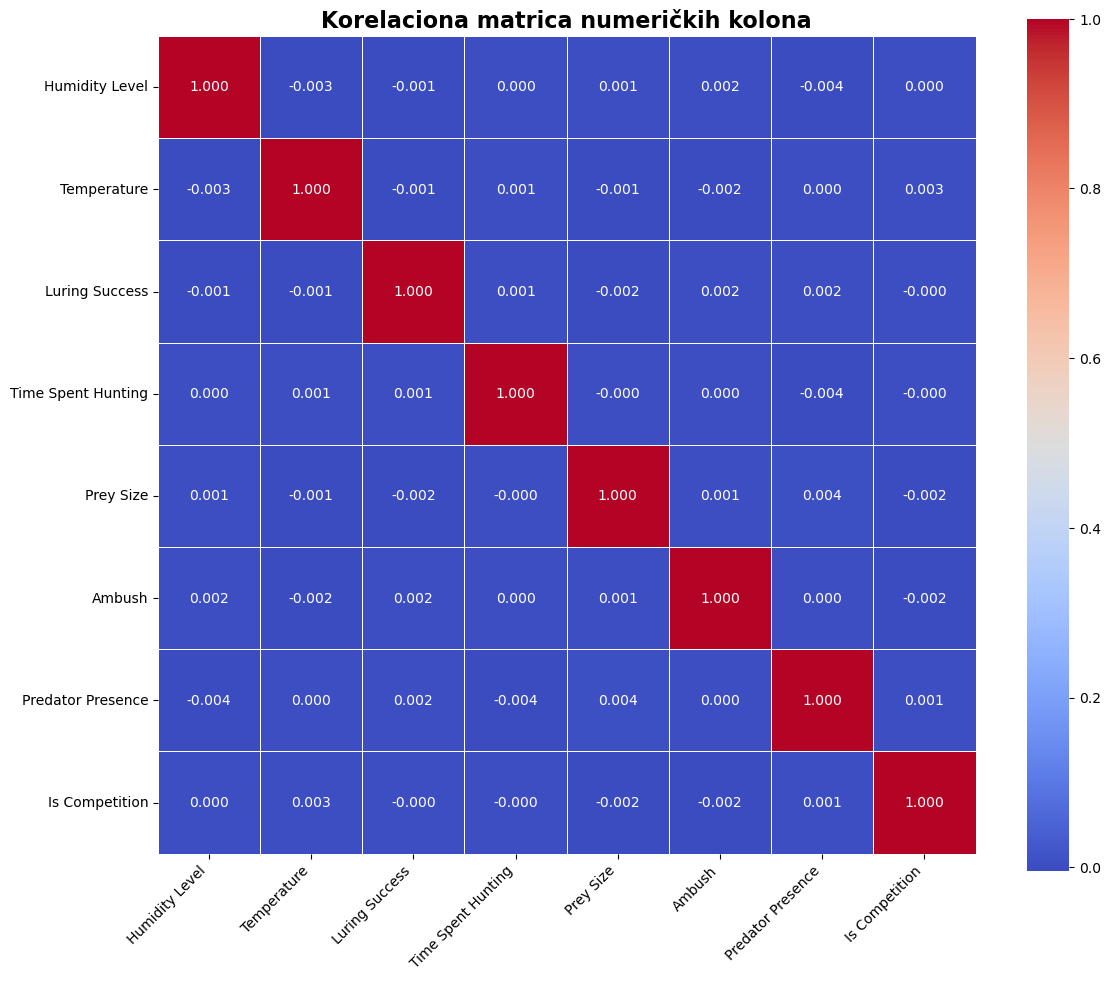

In [21]:
corr_matrix = dataset[num_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.5, square=True)
plt.title('Korelaciona matrica numeričkih kolona', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Korelacija feature sa target kolonom

In [22]:
from scipy.stats import pointbiserialr

for col in dataset.select_dtypes(include='number'):
    corr, p_value = pointbiserialr(dataset["Hunting Success"], dataset[col])
    print(f"{col}: {corr:.4f}")

Humidity Level: 0.0013
Temperature: -0.0002
Luring Success: 0.1110
Time Spent Hunting: 0.1098
Prey Size: 0.1366
Ambush: 0.1880
Predator Presence: -0.0700
Is Competition: -0.0723
Hunting Success: 1.0000


Analiza kategorijskih kolona

In [23]:
cat_cols = dataset.select_dtypes(include=['object']).columns.tolist()
print(f'Kategorijske kolone: {cat_cols}')


Kategorijske kolone: ['Time of Day', 'Food Availability']


Value counts za kategorijske kolone


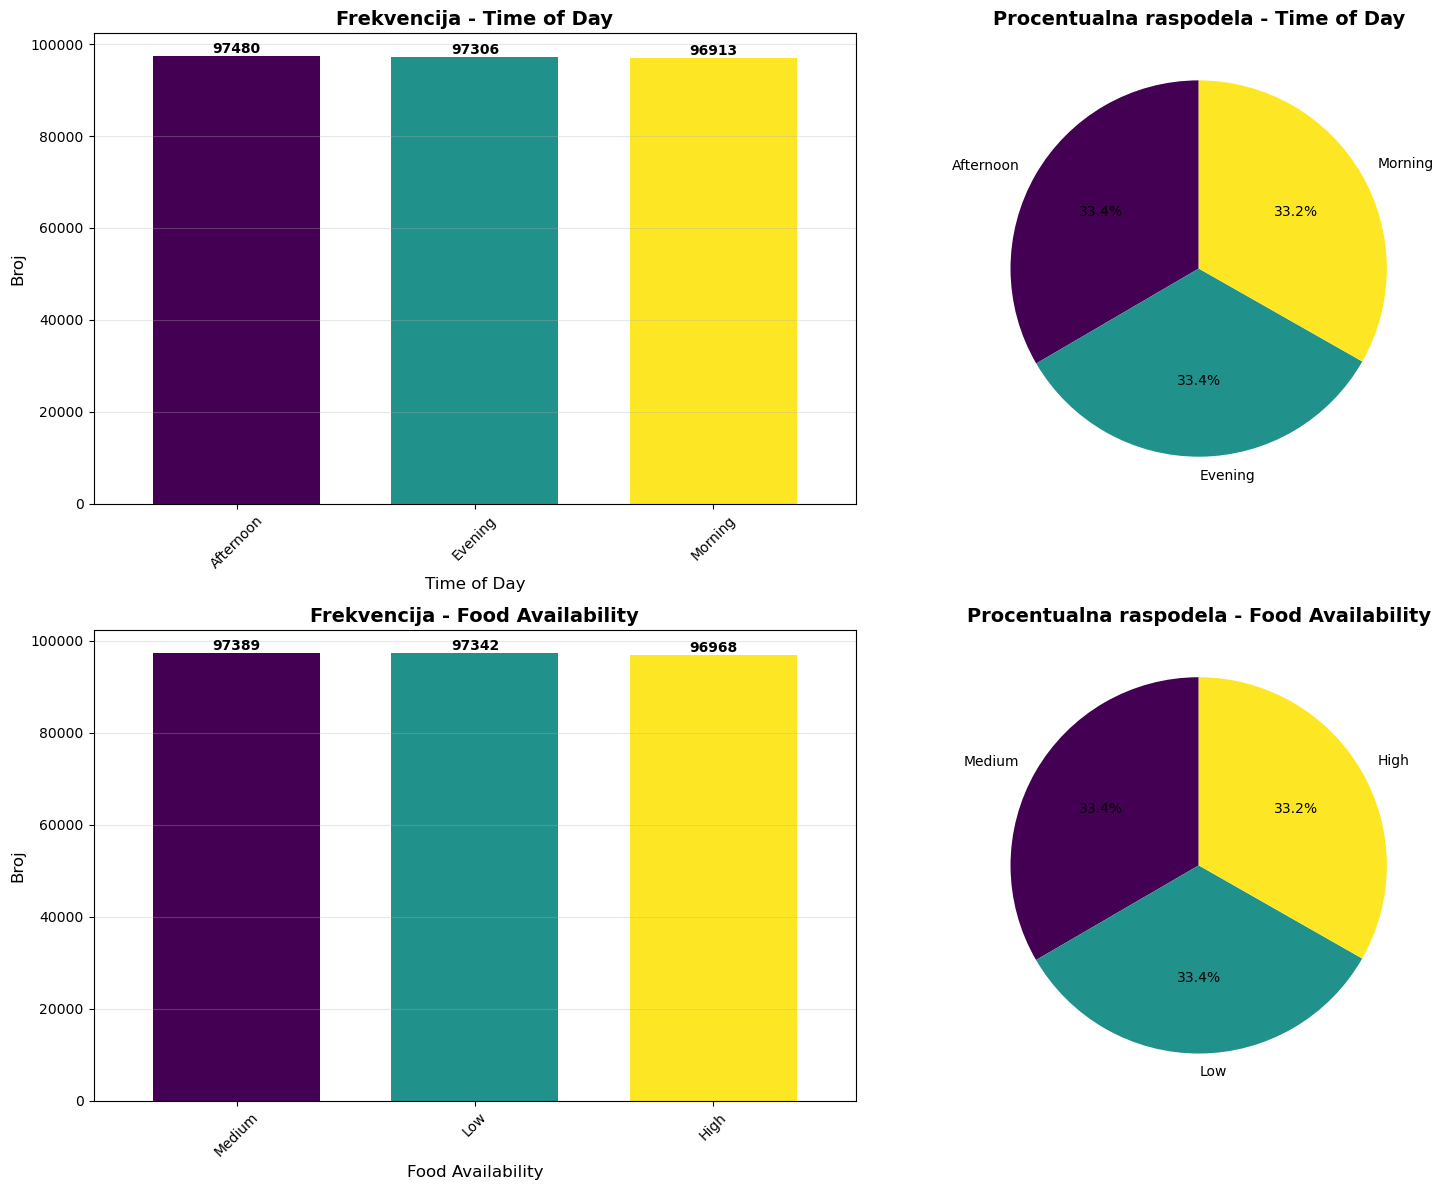

In [24]:
fig, axes = plt.subplots(nrows=len(cat_cols), ncols=2, figsize=(16, 6 * len(cat_cols)))

for i, col in enumerate(cat_cols):
    value_counts = dataset[col].value_counts()
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(value_counts)))
    value_counts.plot(kind='bar', ax=axes[i, 0], color=colors, width=0.7)
    axes[i, 0].set_title(f'Frekvencija - {col}', fontsize=14, fontweight='bold')
    axes[i, 0].set_xlabel(col, fontsize=12)
    axes[i, 0].set_ylabel('Broj', fontsize=12)
    axes[i, 0].tick_params(axis='x', rotation=45)
    axes[i, 0].grid(axis='y', alpha=0.3)
    
    for container in axes[i, 0].containers:
        axes[i, 0].bar_label(container, fmt='%d', fontweight='bold')
    
    axes[i, 1].pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', 
                   startangle=90, colors=plt.cm.viridis(np.linspace(0, 1, len(value_counts))))
    axes[i, 1].set_title(f'Procentualna raspodela - {col}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


Grupisanje kategorijskih kolona po target (Hunting Success)


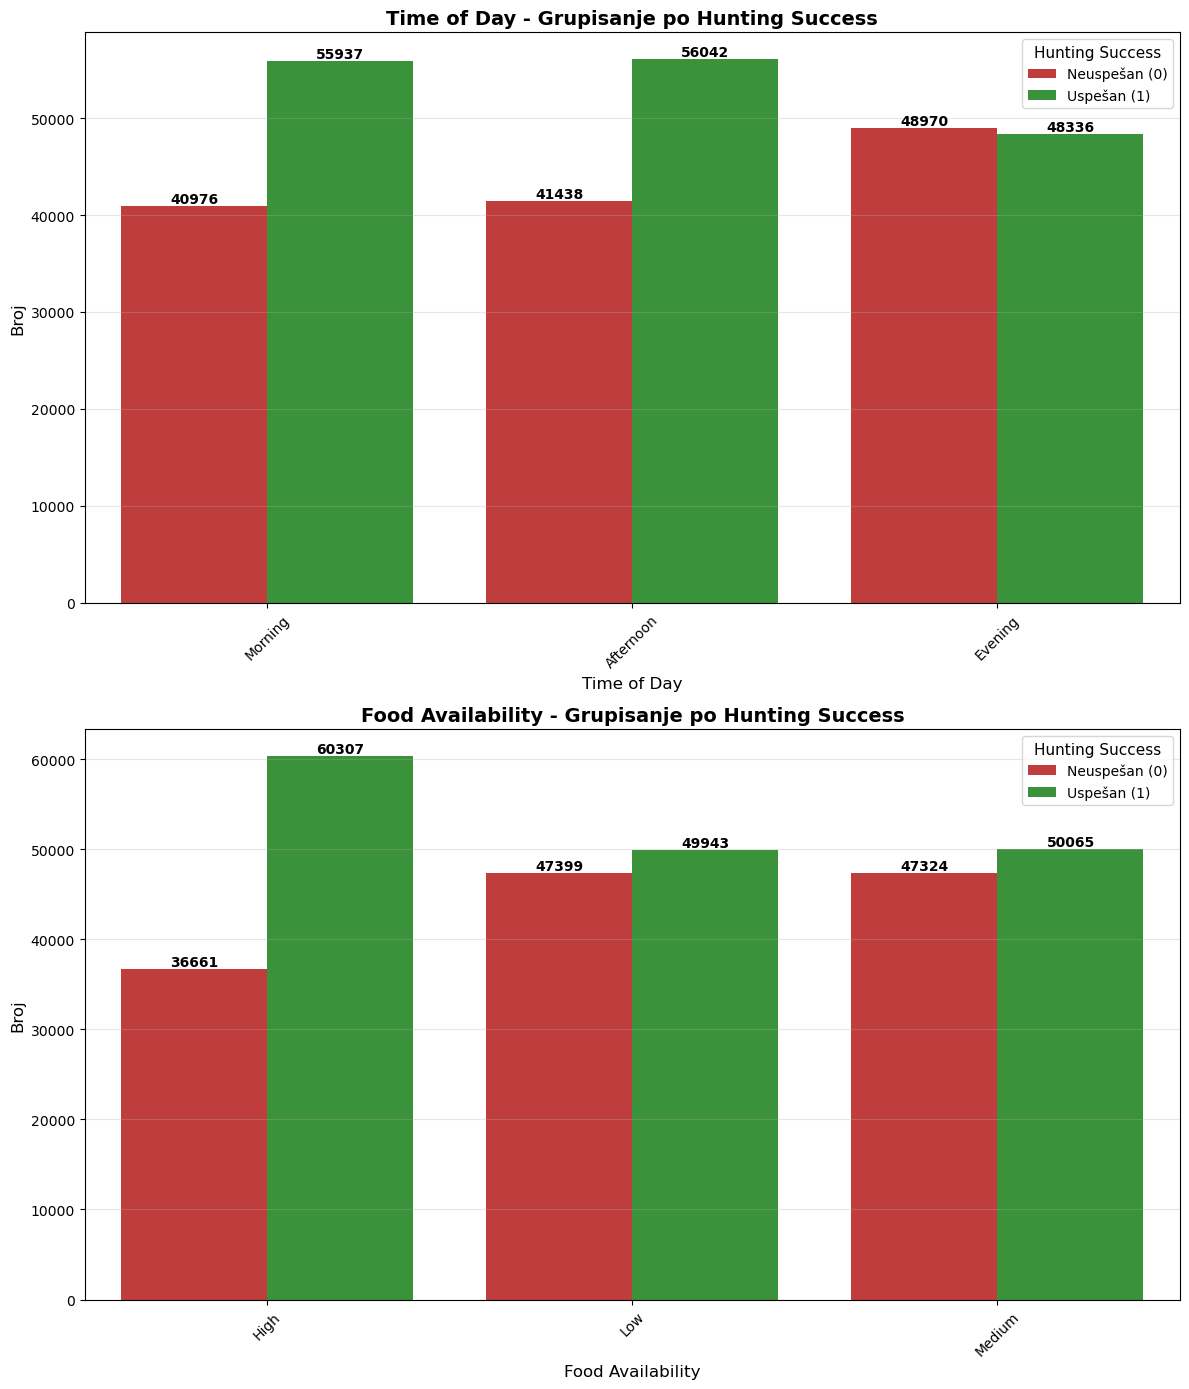

In [25]:
fig, axes = plt.subplots(nrows=len(cat_cols), ncols=1, figsize=(12, 7 * len(cat_cols)))

for i, col in enumerate(cat_cols):
    sns.countplot(data=dataset, x=col, hue='Hunting Success', ax=axes[i], palette=['#d62728', '#2ca02c'])
    axes[i].set_title(f'{col} - Grupisanje po Hunting Success', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Broj', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(title='Hunting Success', labels=['Neuspešan (0)', 'Uspešan (1)'], title_fontsize=11, fontsize=10)
    axes[i].grid(axis='y', alpha=0.3)
    
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%d', fontweight='bold')

plt.tight_layout()
plt.show()


Mode kategorijskih kolona

In [26]:
mode_data = []
 
for col in cat_cols:
    mode_total = dataset[col].mode()
    mode_total_value = mode_total.iloc[0] if len(mode_total) > 0 else None
    mode_total_count = (dataset[col] == mode_total_value).sum() if mode_total_value else 0

    dataset_0 = dataset[dataset['Hunting Success'] == 0]
    mode_0 = dataset_0[col].mode()
    mode_0_value = mode_0.iloc[0] if len(mode_0) > 0 else None
    mode_0_count = (dataset_0[col] == mode_0_value).sum() if mode_0_value else 0

    dataset_1 = dataset[dataset['Hunting Success'] == 1]
    mode_1 = dataset_1[col].mode()
    mode_1_value = mode_1.iloc[0] if len(mode_1) > 0 else None
    mode_1_count = (dataset_1[col] == mode_1_value).sum() if mode_1_value else 0
    mode_data.append({
        'Kategorijska kolona': col,
        'Mode (Ukupno)': mode_total_value,
        'Mode (Hunting Success = 0)': mode_0_value,
        'Mode (Hunting Success = 1)': mode_1_value,
    })
 
mode_df = pd.DataFrame(mode_data)
mode_df

,Kategorijska kolona,Mode (Ukupno),Mode (Hunting Success = 0),Mode (Hunting Success = 1)
0,Time of Day,Afternoon,Evening,Afternoon
1,Food Availability,Medium,Low,High


Analiza uticaja outlier-a na target

Detaljna analiza uticaja outlier-a na target varijablu:



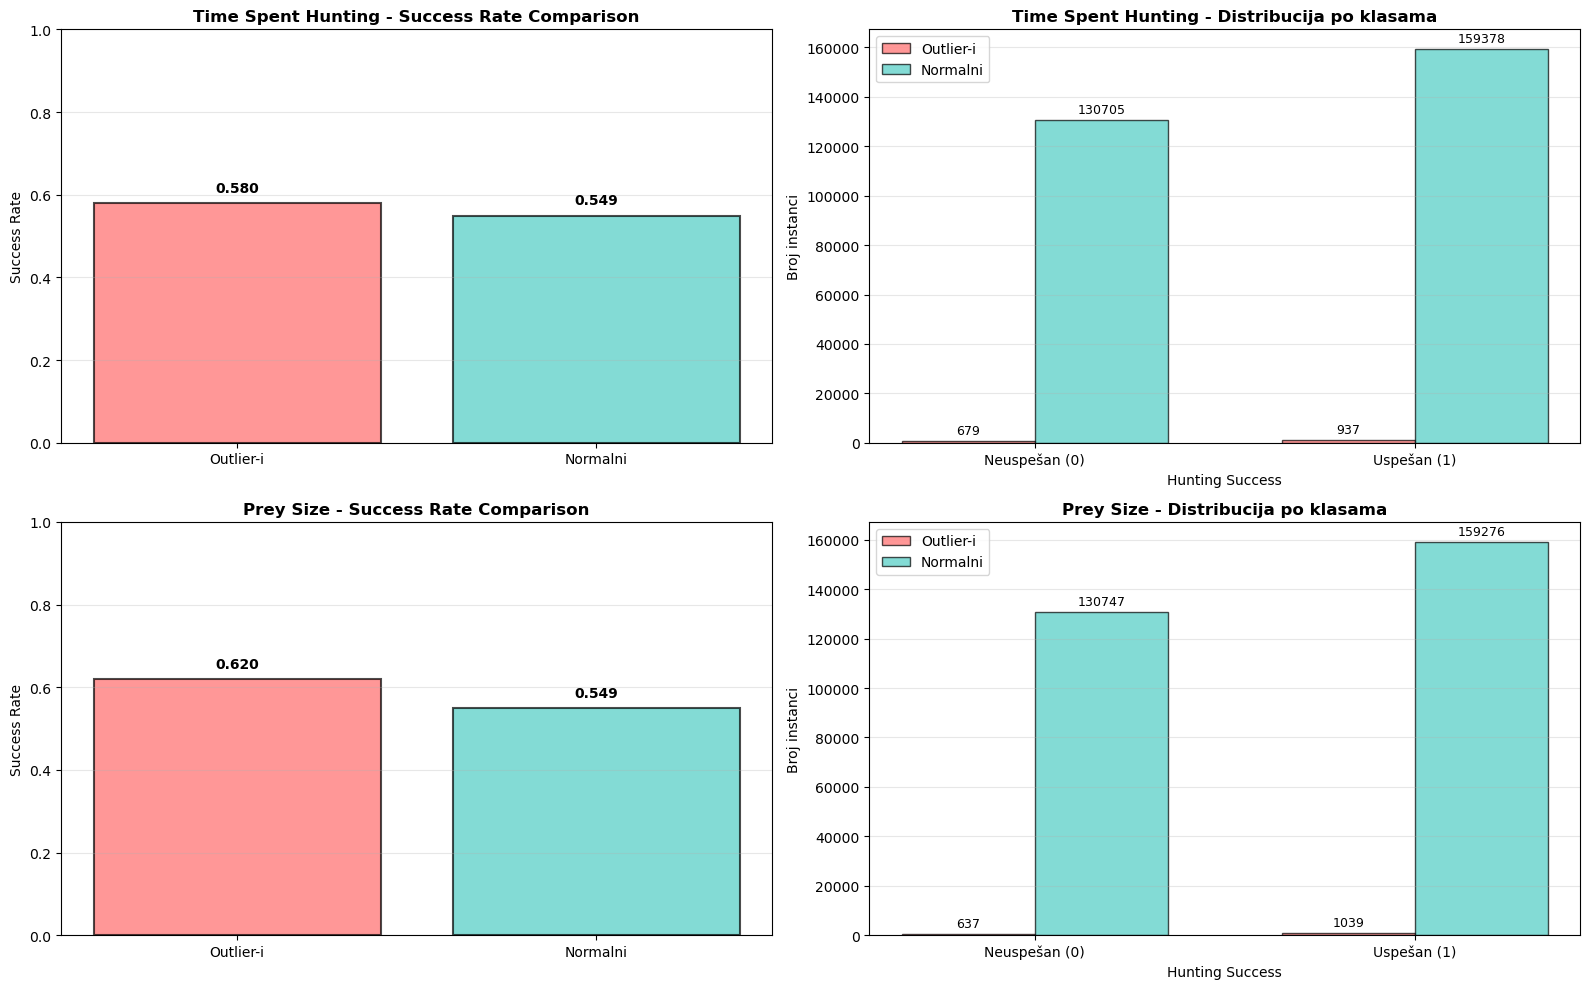

In [27]:
num_cols = dataset.select_dtypes(include=['float', 'int']).columns.tolist()
num_cols.remove('Hunting Success')

# Detaljna analiza uticaja outlier-a na target varijablu
outlier_analysis = []

for col in num_cols:
    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identifikacija outlier-a
    outliers_mask = (dataset[col] < lower_bound) | (dataset[col] > upper_bound)
    normal_mask = ~outliers_mask
    
    outliers_data = dataset[outliers_mask]
    normal_data = dataset[normal_mask]
    
    if len(outliers_data) > 0:
        # Success rate za outlier-e i normalne vrednosti
        outlier_success_rate = outliers_data['Hunting Success'].mean()
        normal_success_rate = normal_data['Hunting Success'].mean()
        
        # Distribucija po klasama za outlier-e
        outlier_dist = outliers_data['Hunting Success'].value_counts()
        outlier_dist_pct = outliers_data['Hunting Success'].value_counts(normalize=True) * 100
        
        # Distribucija po klasama za normalne vrednosti
        normal_dist = normal_data['Hunting Success'].value_counts()
        normal_dist_pct = normal_data['Hunting Success'].value_counts(normalize=True) * 100
        
        # Razlika u success rate-u
        impact = abs(outlier_success_rate - normal_success_rate)
        
        outlier_analysis.append({
            'Kolona': col,
            'Broj outlier-a': len(outliers_data),
            'Procenat outlier-a (%)': f"{(len(outliers_data) / len(dataset) * 100):.2f}%",
            'Success rate (outlier-i)': f"{outlier_success_rate:.4f}",
            'Success rate (normalni)': f"{normal_success_rate:.4f}",
            'Razlika u success rate-u': f"{impact:.4f}",
            'Outlier: Hunting Success = 0': f"{outlier_dist.get(0, 0)} ({outlier_dist_pct.get(0, 0):.2f}%)",
            'Outlier: Hunting Success = 1': f"{outlier_dist.get(1, 0)} ({outlier_dist_pct.get(1, 0):.2f}%)",
            'Normalni: Hunting Success = 0': f"{normal_dist.get(0, 0)} ({normal_dist_pct.get(0, 0):.2f}%)",
            'Normalni: Hunting Success = 1': f"{normal_dist.get(1, 0)} ({normal_dist_pct.get(1, 0):.2f}%)"
        })

outlier_analysis_df = pd.DataFrame(outlier_analysis)
print("Detaljna analiza uticaja outlier-a na target varijablu:\n")
outlier_analysis_df

# Vizualizacija uticaja outlier-a na target
outlier_cols = outlier_analysis_df['Kolona'].tolist()

if len(outlier_cols) > 0:
    fig, axes = plt.subplots(nrows=len(outlier_cols), ncols=2, figsize=(16, 5 * len(outlier_cols)))
    
    if len(outlier_cols) == 1:
        axes = axes.reshape(1, -1)
    
    for i, col in enumerate(outlier_cols):
        Q1 = dataset[col].quantile(0.25)
        Q3 = dataset[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_mask = (dataset[col] < lower_bound) | (dataset[col] > upper_bound)
        outliers_data = dataset[outliers_mask]
        normal_data = dataset[~outliers_mask]
        
        # Graf 1: Success rate comparison
        categories = ['Outlier-i', 'Normalni']
        success_rates = [
            outliers_data['Hunting Success'].mean(),
            normal_data['Hunting Success'].mean()
        ]
        
        axes[i, 0].bar(categories, success_rates, color=['#ff6b6b', '#4ecdc4'], alpha=0.7, edgecolor='black', linewidth=1.5)
        axes[i, 0].set_title(f'{col} - Success Rate Comparison', fontsize=12, fontweight='bold')
        axes[i, 0].set_ylabel('Success Rate', fontsize=10)
        axes[i, 0].set_ylim([0, 1])
        axes[i, 0].grid(axis='y', alpha=0.3)
        
        # Dodavanje vrednosti na barove
        for j, rate in enumerate(success_rates):
            axes[i, 0].text(j, rate + 0.02, f'{rate:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        # Graf 2: Distribucija po klasama
        outlier_counts = outliers_data['Hunting Success'].value_counts().sort_index()
        normal_counts = normal_data['Hunting Success'].value_counts().sort_index()
        
        x = np.arange(2)
        width = 0.35
        
        outlier_values = [outlier_counts.get(0, 0), outlier_counts.get(1, 0)]
        normal_values = [normal_counts.get(0, 0), normal_counts.get(1, 0)]
        
        axes[i, 1].bar(x - width/2, outlier_values, width, label='Outlier-i', color='#ff6b6b', alpha=0.7, edgecolor='black')
        axes[i, 1].bar(x + width/2, normal_values, width, label='Normalni', color='#4ecdc4', alpha=0.7, edgecolor='black')
        
        axes[i, 1].set_xlabel('Hunting Success', fontsize=10)
        axes[i, 1].set_ylabel('Broj instanci', fontsize=10)
        axes[i, 1].set_title(f'{col} - Distribucija po klasama', fontsize=12, fontweight='bold')
        axes[i, 1].set_xticks(x)
        axes[i, 1].set_xticklabels(['Neuspešan (0)', 'Uspešan (1)'])
        axes[i, 1].legend()
        axes[i, 1].grid(axis='y', alpha=0.3)
        
        # Dodavanje vrednosti na barove
        for j, (out_val, norm_val) in enumerate(zip(outlier_values, normal_values)):
            if out_val > 0:
                axes[i, 1].text(j - width/2, out_val + max(outlier_values + normal_values) * 0.01, 
                               str(out_val), ha='center', va='bottom', fontsize=9)
            if norm_val > 0:
                axes[i, 1].text(j + width/2, norm_val + max(outlier_values + normal_values) * 0.01, 
                               str(norm_val), ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
else:
    print("Nema outlier-a u numeričkim kolonama.")


Zapazanje: Outlier-i imaju veći success rate -> veći plen i duže vreme provedeno u lovu = veća uspešnost u lovu
Pretpostavka:  Ekstremne vrednosti su povezane sa većim uspehom, nisu greške u podacima i predstavjaju retke ali važne slučajeve
Odluka: Ne uklanjati outlier-e.
Mogući dalji koraci:
1) Odraditi transformaciju (log/sqrt) ako modeli osetljivi na ekstremne vrednosti imaju problema
2) Dodati feature engineering - npr. binarna kolona Large Prey ili Long Hunt koja eksplicitno označava ekstremne vrednosti

Kolone Time of Day and Food Availability su kategorijske i na njih može da se primeni one-hot encoding

In [28]:
time_of_day_one_hot = pd.get_dummies(dataset['Time of Day'], prefix='Time of Day', dummy_na=False)
food_availability_one_hot = pd.get_dummies(dataset['Food Availability'], prefix='Food Availability', dummy_na=False)

dataset = dataset.drop(columns=['Time of Day', 'Food Availability'])

dataset = pd.concat([dataset, time_of_day_one_hot, food_availability_one_hot], axis=1)

ostale_kolone = [col for col in dataset.columns if col not in list(time_of_day_one_hot.columns) + list(food_availability_one_hot.columns)]
hunting_success_index = ostale_kolone.index('Hunting Success')

nove_kolone = ostale_kolone[:hunting_success_index] + list(time_of_day_one_hot.columns) + list(food_availability_one_hot.columns) + ['Hunting Success'] + ostale_kolone[hunting_success_index + 1:]

dataset = dataset[nove_kolone]

dataset = dataset.replace({True: 1, False: 0})

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 291699 entries, 0 to 299999
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Humidity Level            291699 non-null  float64
 1   Temperature               291699 non-null  float64
 2   Luring Success            291699 non-null  int64  
 3   Time Spent Hunting        291699 non-null  float64
 4   Prey Size                 291699 non-null  float64
 5   Ambush                    291699 non-null  int64  
 6   Predator Presence         291699 non-null  int64  
 7   Is Competition            291699 non-null  int64  
 8   Time of Day_Afternoon     291699 non-null  int64  
 9   Time of Day_Evening       291699 non-null  int64  
 10  Time of Day_Morning       291699 non-null  int64  
 11  Food Availability_High    291699 non-null  int64  
 12  Food Availability_Low     291699 non-null  int64  
 13  Food Availability_Medium  291699 non-null  int64 

Podela dataseta na test i train setove

In [29]:
y = dataset['Hunting Success']
X = dataset.drop(columns=['Hunting Success'])

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

(291699, 14)
(291699,)
X_train shape: (233359, 14)
X_test shape: (58340, 14)


Kreiranje Baseline modela i izbor modela za poredjenje:


In [ ]:

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

  0%|          | 0/32 [00:00<?, ?it/s]